In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "presence-questionnaire" "scanpath-data"

In [2]:
pq <- read.csv("/kaggle/input/presence-questionnaire/presence_questionnaire.csv", comment.char="#")


In [3]:
list.files("/kaggle/input/scanpath-data")

[1] "100" "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111"
[13] "112" "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123"
[25] "124" "126" "127" "128" "129"

In [4]:
getAllEntropies <- function(ntime,nstates){
  #this computes an array of entropies for each individual
  #ntime is the number of time divisions, noting that the sampling
  #rate for eye tracking is 50Hz
  #nstates is the number of divisions of the x-target into segments
  #covering the 360 degrees in front of the participant
  
  
  # List all child directories within the parent directory
  child_dirs <- list.files("/kaggle/input/scanpath-data")
  
  #the rows are the participants and the columms the successive entropies
  allEntropy <- matrix(0,nrow=length(child_dirs),ncol=ntime)
  
  s <- seq(-pi,0,pi/nstates) #this divides the space in front (the x axis)
  s <- cos(s) #the x-coordinate
  ind <- 1 #which individual
  
  timelastchange <- vector() #time of last change of configuration
  #this stores the index into the segmented time period for the last change
  indexlastchange <- vector()
  
  # Loop over each child directory
  for (child_dir in child_dirs) {
    #cat(ind," ",child_dir,"\n")
    
    # Change the working directory to the child directory
    #setwd(child_dir)
    
    # Find the file path
    #f <- list.files()
    f <- list.files(paste0("/kaggle/input/scanpath-data/",child_dir))
    file_path <- f[grep("\\.csv$", f)]

    # Check if the file exists in the child directory
    g <- paste0("/kaggle/input/scanpath-data/",child_dir,"/",file_path)
    if (file.exists(g)) {
      
      # Read the file 
      d <- read.csv(g) 
      x <- d$EyeTrackingTarget_X 
      m <- length(x)
      t <- round(seq(1,m,(m/ntime)))
      t[length(t)+1] <- m
      #intervals are t[i]:t[i+1], i=1,...,nseg-1
      for(j in 1:(length(t)-1)){
        allEntropy[ind,j] <- entropy(s,x[t[j]:t[j+1]])
      }
      
      lastchange <- lastChange(d)
      #actual time of the last change
      timelastchange[ind] <- d$Seconds[lastchange]- d$Seconds[1]
      #indexlastchange[ind] <- findInterval(timelastchange[ind],t) + 1
      indexlastchange[ind] <- findInterval(round(lastchange),t)
      
    } else {
      warning(paste("File", file_path, "does not exist in directory", child_dir))
    }
    
    # Change back to the parent directory
    ind = ind+1
    setwd("..")
  }
  #allEntropy <- allEntropy[,-ntime]
  return(list(allEntropy = allEntropy,timelastchange =timelastchange, indexlastchange=indexlastchange))
  
}

In [5]:
entropy <- function(states,x){
  #states is a sequence of intervals states[1], states[2] corresponding to segments 
  #on the target x axis dividing the scene in front.
  #x is a sequence of x values in the range -1 to 1 corresponding to observed
  #target eye movements
  
  #finds the frequency distribution of x by the segments s
  freq <- hist(x, breaks = states, plot = FALSE)
  p <- freq$counts/sum(freq$counts) #the probabilities
   
  return( -sum(ifelse(p == 0, 0, p * log2(p))) )

}

In [6]:
lastChange <- function(d){
  
  data_matrix <- cbind(d$Stereopsis, d[["6DoF"]], d$SpatialAudio, d$HighResolution, d$AltColour)
  
  # Convert each row to a binary number
  binary_numbers <- apply(data_matrix, 1, function(row) {
    sum(2^(which(rev(row) == 1) - 1))
  })
  
  # Find the index of the last change
  last_change_index <- max(which(c(TRUE, diff(binary_numbers) != 0)))
  
  return(last_change_index)
}

In [7]:
a <- getAllEntropies(30,18)

In [8]:
#note to plot the mean over all participants of entropies by time use
t <- seq(1,30)
et <- apply(a$allEntropy,2,mean)
cor.test(t,et)


	Pearson's product-moment correlation

data:  t and et
t = -4.6165, df = 28, p-value = 7.91e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.8228013 -0.3893542
sample estimates:
       cor 
-0.6574073 


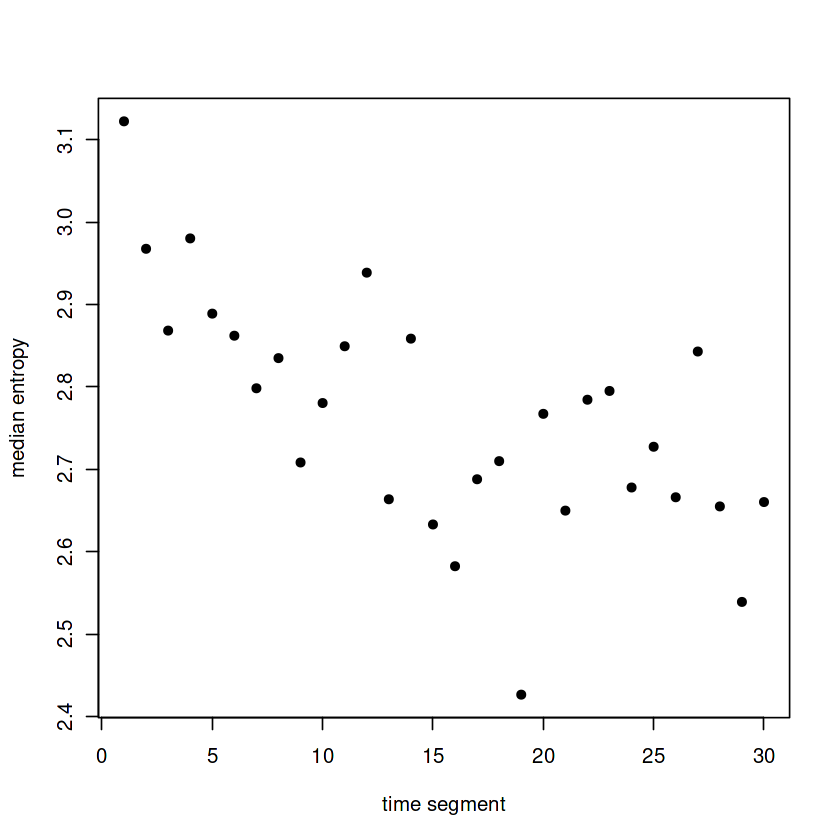

In [9]:
plot(t,et,xlab="time segment",ylab = "median entropy",pch=16)

In [10]:
entropyByLastChange <- function(a){
  #a is the result of getAllEntropies
  #here we save the entropy corresponding to the last change
  w <- vector()
  n <- dim(a$allEntropy)
  n <- n[1]
  
  for(i in 1:n[1]){
    w[i] <- a$allEntropy[i,a$indexlastchange[i]]
  }
  return(w)
  
}

In [11]:
elast <- entropyByLastChange(a)

In [12]:
PI <- matrix(data = c(pq$there,pq$reality,pq$place,pq$virtualplace),nrow=29,ncol=4)
PI_median <- apply(PI,1,median)

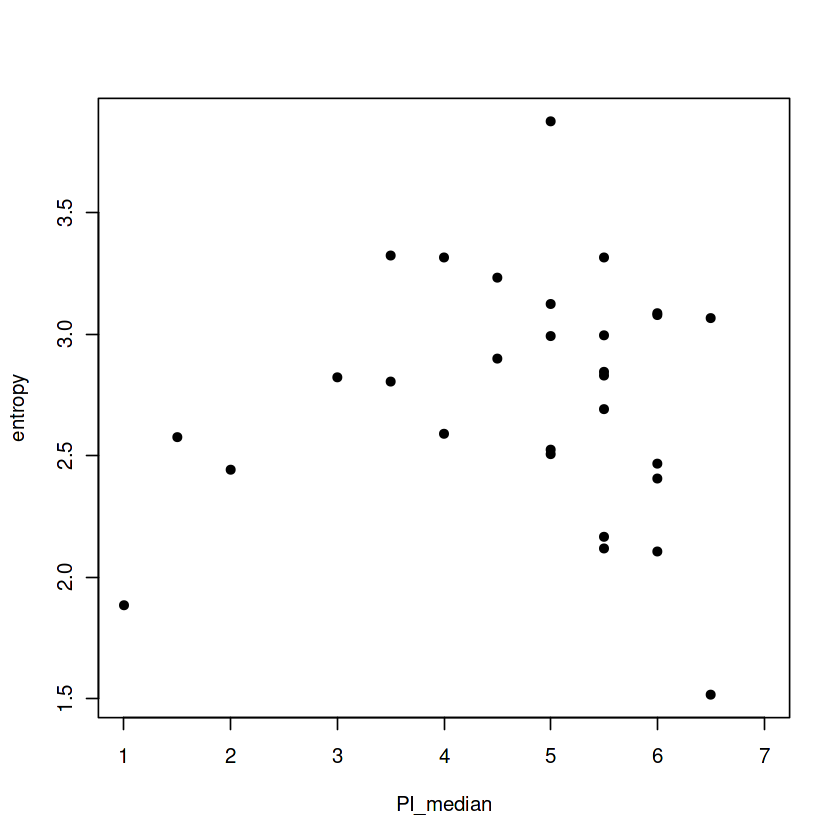

In [13]:
plot(PI_median,elast,xlab="PI_median",ylab="entropy",xlim=c(1,7), pch=16)

In [14]:
PI_median2 <- PI_median^2
lm <- lm(elast ~ PI_median + PI_median2)
summary(lm)

cor.test(elast[PI_median>=3],PI_median[PI_median>=3])


Call:
lm(formula = elast ~ PI_median + PI_median2)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8005 -0.2095 -0.0914  0.2643  0.9476 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  1.17197    0.54851   2.137  0.04221 * 
PI_median    0.93495    0.29391   3.181  0.00378 **
PI_median2  -0.11674    0.03668  -3.183  0.00376 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4391 on 26 degrees of freedom
Multiple R-squared:  0.2823,	Adjusted R-squared:  0.2271 
F-statistic: 5.113 on 2 and 26 DF,  p-value: 0.01341



	Pearson's product-moment correlation

data:  elast[PI_median >= 3] and PI_median[PI_median >= 3]
t = -1.8713, df = 24, p-value = 0.07354
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.65381454  0.03541412
sample estimates:
       cor 
-0.3568328 


In [15]:
#Running 1000 times doesn't work on Kaggle, it takes too long.
#Instead I will illustrate it with 10 times.
#let's sample over the time periods and the number of states
#the total time is 20 minutes so let's sample randomly


e10 <- rep(0,29)
N <- 10
for(i in 1:N) {
  ntime <- round(runif(1,5,40))
  nstates <- round(runif(1,3,30))
  a <- getAllEntropies(ntime,nstates)
  e10 <- e10 + entropyByLastChange(a)
  cat("i = ",i," ","ntime = ",ntime,"nstates = ",nstates, "\n")
  flush.console()
}
e10 <- e10/N


i =  1   ntime =  24 nstates =  14 
i =  2   ntime =  23 nstates =  5 
i =  3   ntime =  39 nstates =  28 
i =  4   ntime =  11 nstates =  5 
i =  5   ntime =  6 nstates =  13 
i =  6   ntime =  17 nstates =  13 
i =  7   ntime =  34 nstates =  29 
i =  8   ntime =  24 nstates =  8 
i =  9   ntime =  22 nstates =  26 
i =  10   ntime =  27 nstates =  25 


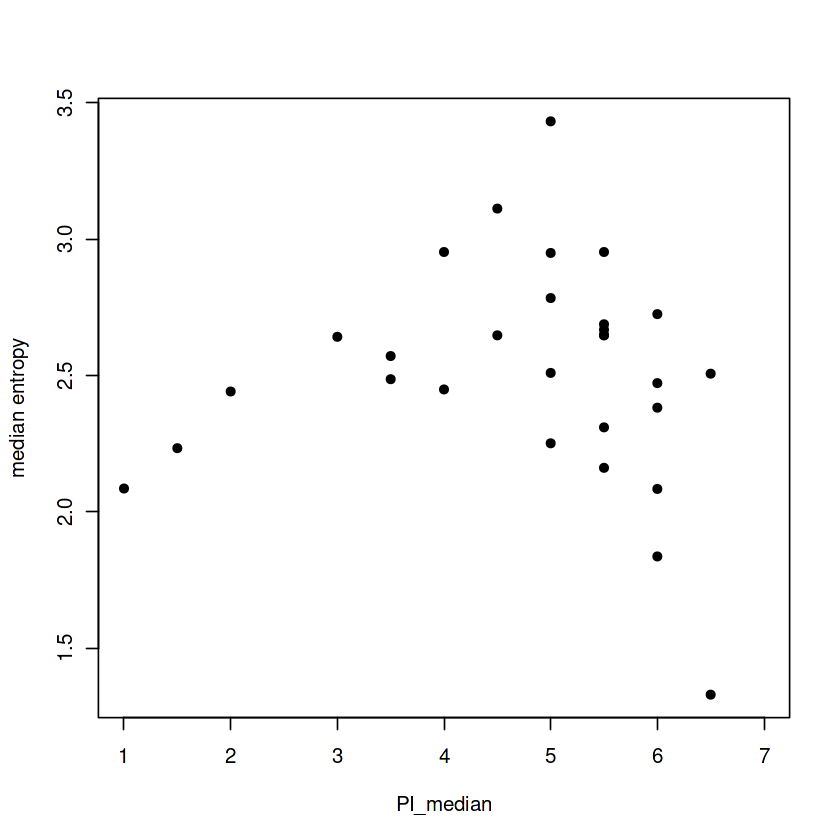

In [16]:
plot(PI_median,e10,xlim=c(1,7),ylab="median entropy", pch=16)


In [17]:
#Stan analysis
library("rstan")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract




In [18]:
mydata <- list(
            N = length(PI_median),
            pres = PI_median,
            entropy = e10
)


In [19]:
stan_model <- "
data {
  int<lower=0> N;       // Number of data points
  vector[N] pres;       // Independent variable
  vector[N] entropy;    // Dependent variable
}

parameters {
  vector[3] b;                 
  real<lower=0> sigma;      
  real<lower=1> v;      //degrees of freedom
}

model {
  // Priors
  b ~ normal(0, 10);
  sigma ~ gamma(2,0.1);
  v ~ gamma(2,0.1);

  // Likelihood
  for(i in 1:N) {
      entropy[i] ~ student_t(v, b[1] + b[2]*pres[i] + b[3]*(pres[i]^2), sigma);
  }
}

generated quantities {
  vector[N] entropy_new;
  vector[N] log_lik_entropy;
  real m;
  
  for(i in 1:N){
    m = b[1] + b[2]*pres[i] + b[3]*(pres[i]^2);
    entropy_new[i] = student_t_rng(v,m, sigma);
    log_lik_entropy[i] = student_t_lpdf(entropy[i]|v,m, sigma);
  }
}
"

In [20]:
fit <- stan (model_code = stan_model, # Stan program
              data = mydata, # named list of data
              chains = 4, # number of Markov chains
              iter = 3000, # total number of iterations per chain
              cores = 4,
              #control = list(max_treedepth = 12),
              seed=54321)


In [21]:
print(fit, pars=c("b","sigma","v"),probs=c(.025,.975))

Inference for Stan model: anon_model.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

       mean se_mean    sd  2.5% 97.5% n_eff Rhat
b[1]   1.29    0.01  0.46  0.31  2.16  1745    1
b[2]   0.77    0.01  0.25  0.29  1.30  1595    1
b[3]  -0.10    0.00  0.03 -0.17 -0.04  1662    1
sigma  0.34    0.00  0.06  0.25  0.47  2710    1
v     21.83    0.24 13.99  4.45 57.35  3493    1

Samples were drawn using NUTS(diag_e) at Sun Dec 10 11:48:40 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
e <- rstan::extract(fit)

In [23]:
#probabilities of the parameters being positive
mean(e$b[,1]>0)
mean(e$b[,2]>0)
mean(e$b[,3]>0)

[1] 0.9946667

[1] 0.9991667

[1] 0.001

In [24]:
#find the probability that the degrees of freedom might be less than 30
mean(e$v < 30)

[1] 0.7738333

In [25]:
#obtain the means of the parameters forming the quadratic
b0 <- mean(e$b[,1])
b1 <- mean(e$b[,2])
b2 <- mean(e$b[,3])

In [26]:
#now plot the quadratic over the data points
p <- seq(1,7,0.1)
ent <- b0 + b1*p + b2*(p^2)

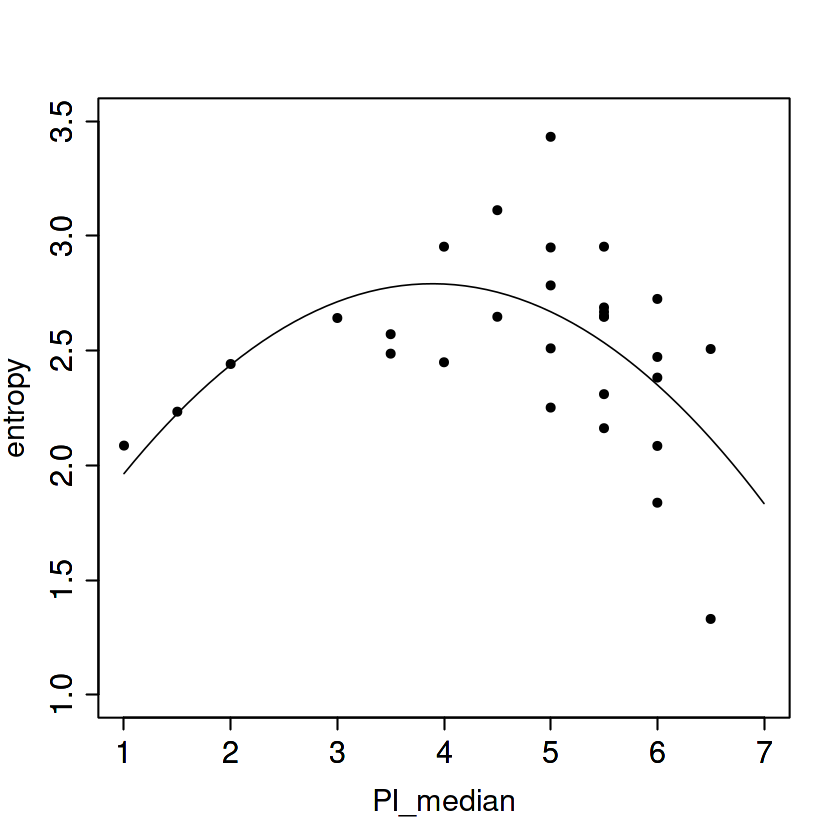

In [27]:
sz <- 1.5
plot(p, ent, type="l", ylim=c(1,3.5), xlim=c(1,7), xlab="", ylab="", 
     cex.lab=sz, cex.axis=sz)
par(new=TRUE)
plot(PI_median, e10, ylim=c(1,3.5), xlim=c(1,7), ylab="entropy", 
     pch=16, cex.lab=sz, cex.axis=sz)



	Pearson's product-moment correlation

data:  e10 and apply(e$entropy_new, 2, mean)
t = 3.7701, df = 27, p-value = 0.0008103
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2813103 0.7848456
sample estimates:
      cor 
0.5872676 


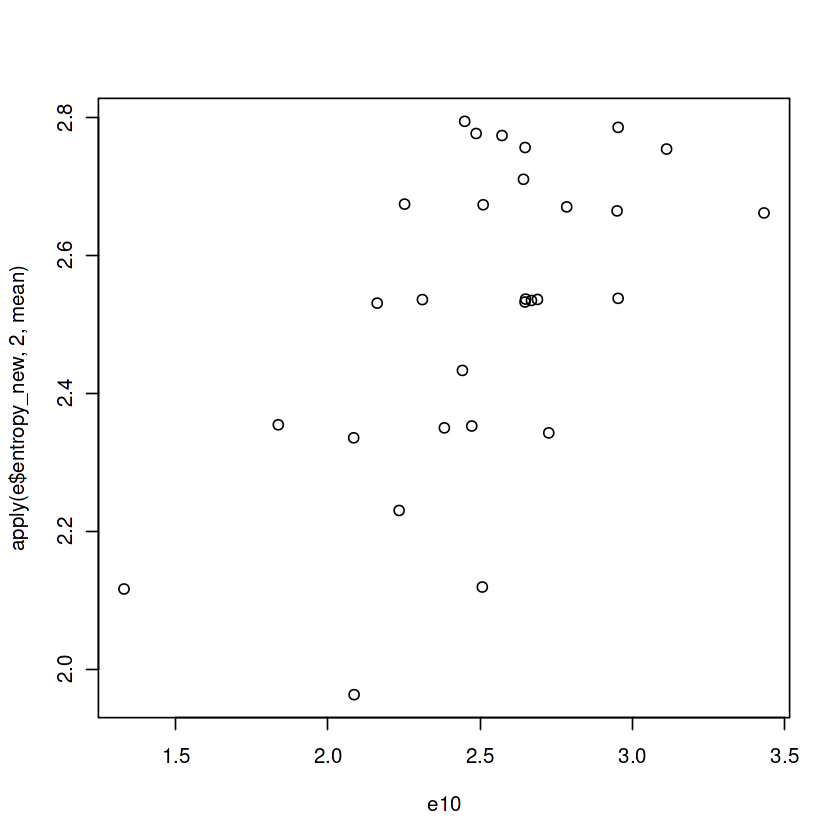

In [28]:
#plot observed against predicted posterior distribution means
plot(e10,apply(e$entropy_new,2,mean))
cor.test(e10,apply(e$entropy_new,2,mean))

In [29]:
loo_summary <- function(fit, name) {

  log_lik <- extract_log_lik(fit, merge_chains = FALSE,parameter_name=name)
  r_eff <- relative_eff(exp(log_lik))
  loo <- loo(log_lik, r_eff = r_eff, cores = 2)
  return(loo)
}

In [30]:
library("loo")
loo <- loo_summary(fit,"log_lik_entropy")
loo

This is loo version 2.6.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 


Attaching package: ‘loo’


The following object is masked from ‘package:rstan’:

    loo


Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”



Computed from 6000 by 29 log-likelihood matrix

         Estimate  SE
elpd_loo    -13.0 4.0
p_loo         4.0 1.2
looic        25.9 8.1
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     27    93.1%   1368      
 (0.5, 0.7]   (ok)        2     6.9%   302       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.